In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter
import os
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten
import keras

2025-01-11 19:17:57.792483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-11 19:17:57.792652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-11 19:17:57.949892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_train='/kaggle/input/arabic-chars-mnist/train'
data_test='/kaggle/input/arabic-chars-mnist/test'

In [3]:
# List the files in the dataset directory 
file_train = os.listdir(data_train)
file_test = os.listdir(data_test)

arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
print("Labels: " , arabic_labels)


Labels:  ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal', 'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']


In [4]:
#function for extract class name from file name
import re
def class_name(fname):
    parts = re.split(r'(\d+)', fname)
    return ' '.join(parts[:-2])

In [5]:
class_name(file_train[8])


'hah'

In [6]:
# Initialize empty lists for train and test images and labels
train_imag_labels = []
test_images_labels = []

# Load the train images and labels
for file_name in file_train:
    if file_name.endswith('.jpg'):
        # Load the image using OpenCV
        image = cv2.imread(os.path.join(data_train, file_name))
        # Append the image to the train images list
        train_imag_labels.append([image,class_name(file_name)])
# Load the test images and labels
for file_name in file_test:
    if file_name.endswith('.jpg'):
        # Load the image using OpenCV
        image = cv2.imread(os.path.join(data_test, file_name))
        # Append the image to the test images list
        test_images_labels.append([image,class_name(file_name)])
        


In [7]:
#converting the train list to dataframe
dataframe_train=pd.DataFrame(train_imag_labels,columns = ['image','label'])

In [8]:
dataframe_train.head()

,image,label
0,"[[[80, 1, 68], [80, 1, 68], [83, 0, 71], [85, ...",alef
1,"[[[87, 0, 68], [85, 0, 68], [81, 1, 68], [78, ...",ain
2,"[[[87, 0, 68], [85, 1, 66], [83, 1, 66], [80, ...",beh
3,"[[[83, 0, 68], [83, 0, 68], [83, 0, 68], [83, ...",teh
4,"[[[81, 0, 71], [81, 0, 69], [81, 0, 69], [80, ...",teh


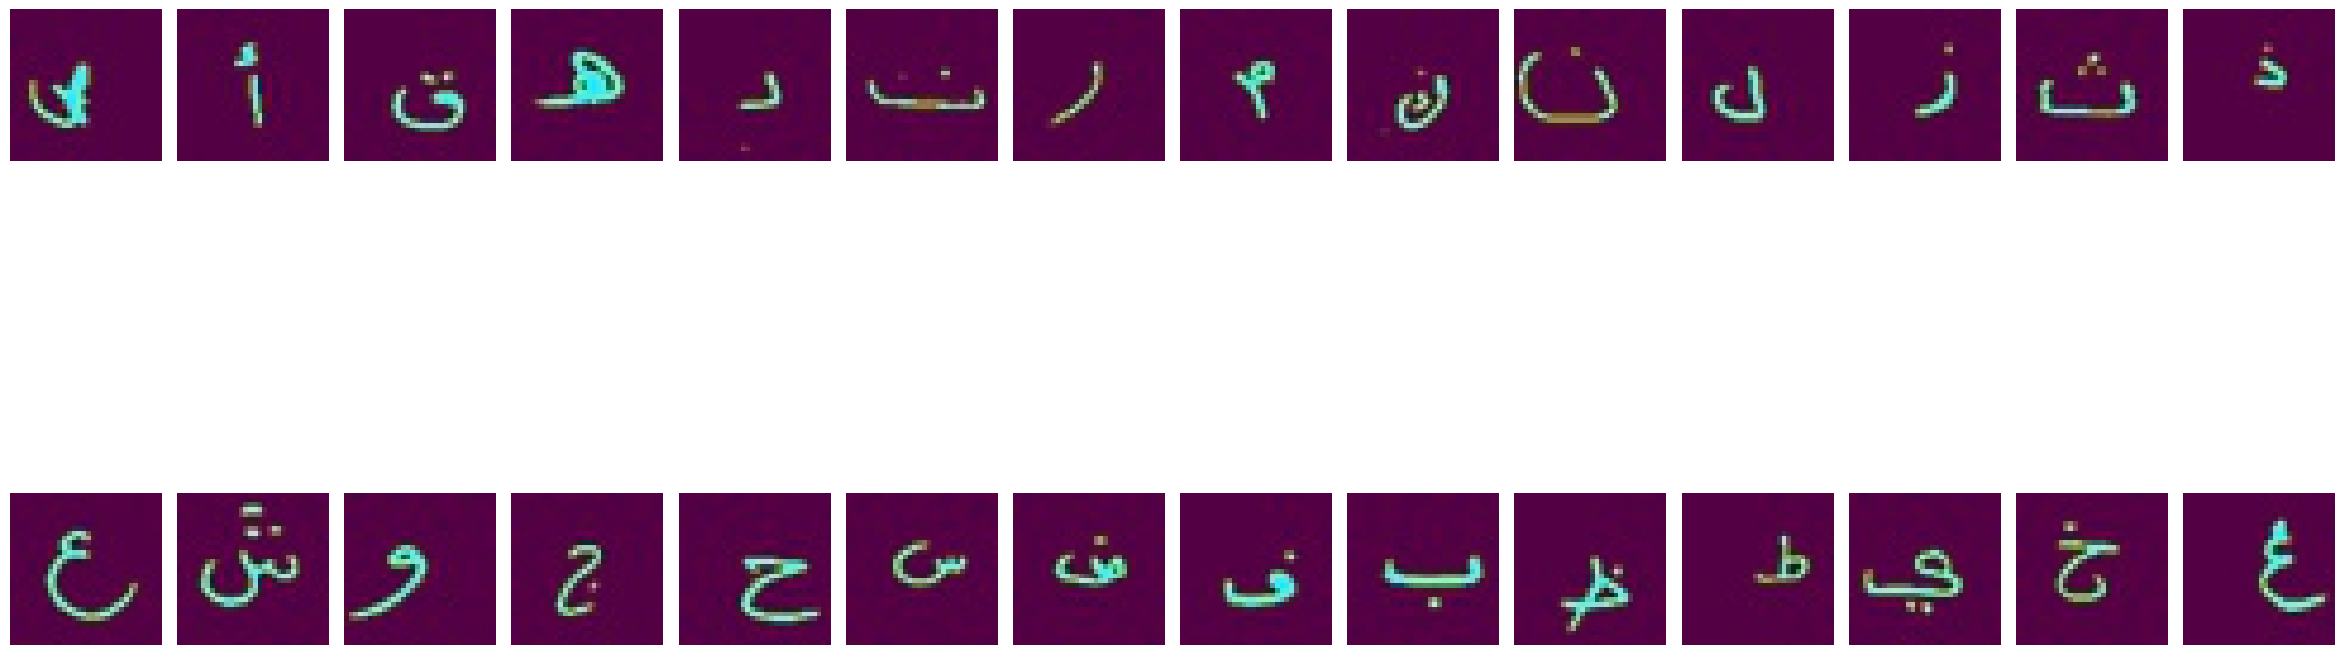

In [9]:
fig, ax = plt.subplots(2, 14, figsize=(30, 12))

labels = set(dataframe_train['label'])
labels = list(labels)[:28]  # Select the first 28 unique labels

for i, name in enumerate(labels):
    row = i // 14  # Calculate the row index
    col = i % 14  # Calculate the column index

    sample = dataframe_train[dataframe_train['label'] == name].sample(1)
    image = sample['image'].item()

    ax[row, col].imshow(image)
    ax[row, col].axis('off')

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

In [10]:
#reshape the train images to be sutable to enter the dl model (sample size,h,w,RGB)
N = dataframe_train.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, image in enumerate((dataframe_train['image'])):
    x_train[i, :, :, :] = image


In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.title('sample image')
plt.imshow(x_train[1])

In [ ]:
#converitng test list to dataframe  Accessing and inspecting the data
#Splitting the data into features (images) and targets (labels)
#Applying data transformations or preprocessing steps
dataframe_test = pd.DataFrame(test_images_labels, columns=['image', 'label'])
dataframe_test.head()


,image,label
0,"[[[78, 3, 65], [80, 3, 65], [81, 1, 66], [83, ...",alef
1,"[[[83, 0, 69], [83, 0, 69], [83, 0, 69], [83, ...",dad
2,"[[[80, 0, 69], [81, 0, 69], [83, 0, 72], [83, ...",teh
3,"[[[73, 3, 66], [76, 3, 65], [87, 2, 64], [88, ...",beh
4,"[[[83, 0, 68], [83, 0, 68], [83, 0, 68], [83, ...",seen


In [ ]:
#reshape the test images 
N = dataframe_test.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, image in enumerate((dataframe_test['image'])):
    x_test[i, :, :, :] = image

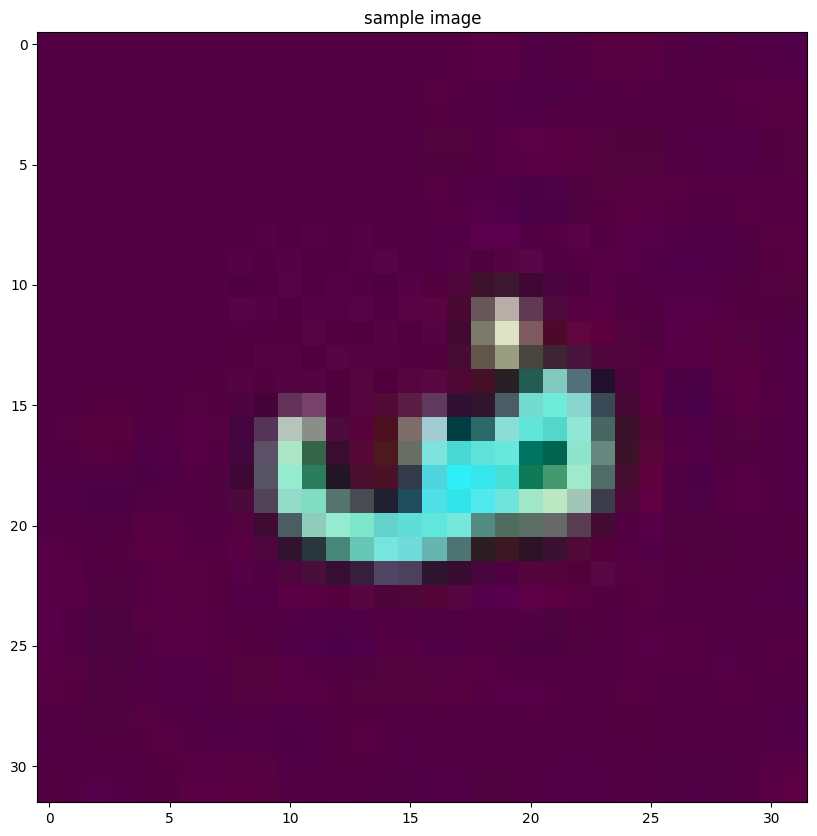

In [14]:
fig=plt.figure(figsize=(20, 10))
plt.title('sample image')
plt.imshow(x_test[1])

In [15]:
print('Shape of train images:',x_train[10] .shape)
print('Shape of train images:', x_test[40].shape)


Shape of train images: (32, 32, 3)
Shape of train images: (32, 32, 3)


In [16]:
#converting labels from string to int
laEncoder=LabelEncoder()
y_train=laEncoder.fit_transform(dataframe_train['label'])
print(y_train)

[1 0 2 ... 7 1 5]


In [17]:
#convert integer labels into one-hot encoded vectors
y_train=to_categorical(y_train, num_classes=28)
print(y_train)

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
# Define the model architecture
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(18, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(28, activation='softmax')  # num_classes represents the number of character classes
])

In [25]:
model.summary()                                                                 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 18)     │        10,386 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 18)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        10,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │         1,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 304,238 (1.16 MB)

 Trainable params: 304,238 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
# Train the model
history=model.fit(x_train, y_train,
          validation_split=0.3,
          epochs=10, batch_size=32, verbose=1)

Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.1439 - loss: 3.3501 - val_accuracy: 0.4913 - val_loss: 1.5227
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.5692 - loss: 1.2650 - val_accuracy: 0.7096 - val_loss: 0.8561
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7397 - loss: 0.7492 - val_accuracy: 0.7835 - val_loss: 0.6335
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8194 - loss: 0.5074 - val_accuracy: 0.8224 - val_loss: 0.5402
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8640 - loss: 0.3880 - val_accuracy: 0.8514 - val_loss: 0.4706
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8835 - loss: 0.3353 - val_accuracy: 0.8534 - val_loss: 0.4622
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9161 - loss: 0.2463 - val_accuracy: 0.8502 - val_loss: 0.4558
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9213 - loss: 0.2417 - 

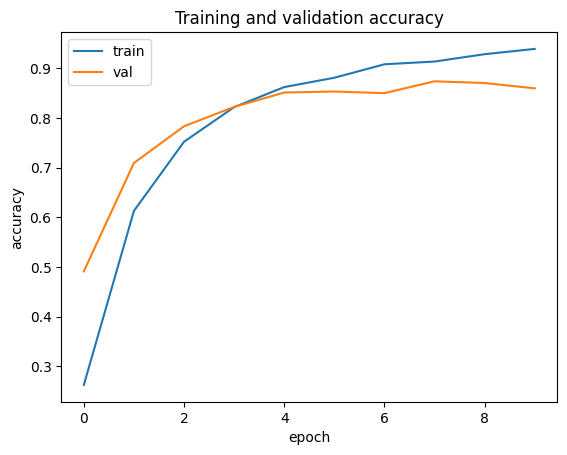

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

the model exhibits high training and validation accuracy throughout most of the training process. The validation accuracy reaches a peak value of 0.9085 in the final epoch, indicating good generalization performance. The training and validation losses also show a mixed pattern of increase and decrease but generally remain relatively low

In [29]:
model.save('cnn.h5')


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


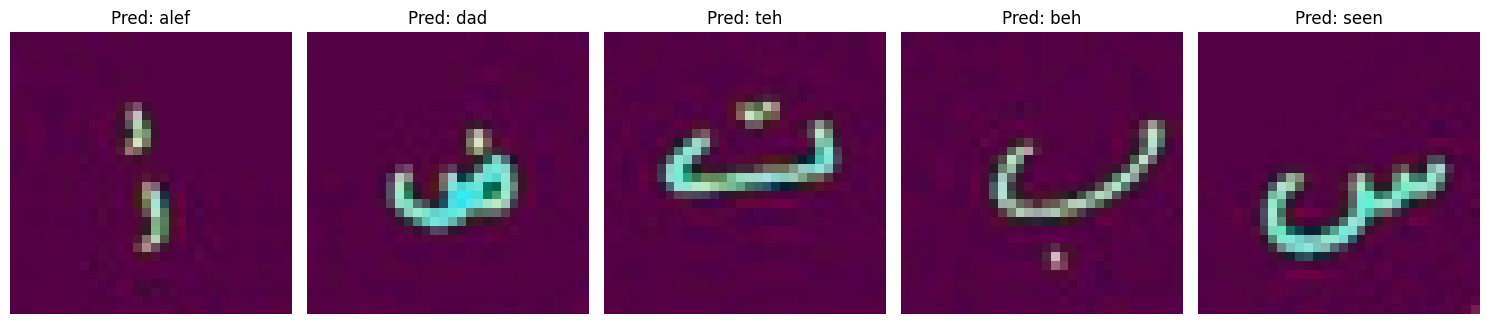

In [34]:
import matplotlib.pyplot as plt

# Generate predictions for the test data
predictions = model.predict(x_test)

# Identify the class with the highest predicted probability for each sample
predicted_classes = np.argmax(predictions, axis=1)

# Decode the predicted class indices back to their original label values
decoded_predictions = laEncoder.inverse_transform(predicted_classes)

# Visualize the first 5 samples from x_test along with their predicted labels
plt.figure(figsize=(15, 8))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')  # Adjust 'cmap' for non-grayscale images
    plt.title(f"Pred: {decoded_predictions[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
